In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.backend import argmax, cast
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Embedding, RepeatVector, Reshape, Conv1D, MaxPooling1D, UpSampling1D, Bidirectional, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback

In [4]:
M = 8

minor_df = pd.read_csv(f"Datasets/datasets/traxsource_0-5000_bassline_representations_min_M{M}.csv", header=None)
major_df = pd.read_csv(f"Datasets/datasets/traxsource_0-5000_bassline_representations_maj_M{M}.csv", header=None)

In [5]:
minor_df.shape, major_df.shape

((3859, 65), (409, 65))

In [6]:
all_data = pd.concat((minor_df.iloc[:,1:].astype(int), major_df.iloc[:,1:].astype(int)))
minor_data = minor_df.values[:,1:].astype(int)
major_data = major_df.values[:,1:].astype(int)

In [7]:
minor_data

array([[ 0, 37, 37, ..., 37, 37, 24],
       [ 0, 37, 37, ..., 37, 37, 12],
       [ 0, 12, 37, ...,  7, 37, 10],
       ...,
       [ 0, 12,  0, ...,  0, 37, 24],
       [ 0, 37, 14, ..., 19,  0, 10],
       [ 0, 37, 37, ..., 37, 37, 26]])

In [8]:
notes = np.unique(all_data)
vocab = np.arange(len(notes))

n2v_mapping = dict(zip(notes, vocab))
v2n_mapping = dict(zip(vocab, notes))

vocab_size = len(n2v_mapping)

def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    # Drop the magic bomb with searchsorted to get the corresponding
    # places for a in keys (using sorter since a is not necessarily sorted).
    # Then trace it back to original order with indexing into sidx
    # Finally index into values for desired output.
    return v[sidx[np.searchsorted(k,ar,sorter=sidx)]]

minor_data = replace_with_dict(minor_data, n2v_mapping).astype(int)
major_data = replace_with_dict(major_data, n2v_mapping).astype(int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(minor_data, minor_data, test_size=0.2, random_state=42)

In [10]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]
timesteps = X_train.shape[1]

In [11]:
#def replace_continue(arr, cont_token):
#    for r in arr:
#        for idx, el in enumerate(r[1:]):
#            if el == cont_token:
#                r[idx + 1] = r[idx]
#
#cont_token = 35
#
#
#replace_continue(X_train, cont_token)
#replace_continue(y_train, cont_token)
#replace_continue(X_test, cont_token)
#replace_continue(y_test, cont_token)

In [12]:
def one_hot_encode(arr, encode_length):
    return np.eye(encode_length)[arr.astype(np.uint)]

In [13]:
y_train = one_hot_encode(y_train, vocab_size)
y_test = one_hot_encode(y_test, vocab_size)

## Model 1: Embedding-LSTM Encoder, LSTM-Dense Decoder

In [12]:
wandb.init(project='Keras_runs', entity='nbg')

wandb: Currently logged in as: udemir15 (use `wandb login --relogin` to force relogin)


In [13]:
name = 'NBG_lstm'

In [14]:
#timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
#encoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(embedded)
encoded = LSTM(latent_dim, dropout=dropout)(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [15]:
sequence_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1216      
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 64, 38)            9766      
Total params: 832,230
Trainable params: 832,230
Non-trainable params: 0
_______________________________________________________

In [16]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [17]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1216      
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
Total params: 297,152
Trainable params: 297,152
Non-trainable params: 0
_________________________________________________________________


In [18]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 64, 38)            9766      
Total params: 535,078
Trainable params: 535,078
Non-trainable params: 0
_________________________________________________________________


In [19]:
learning_rate = 5e-3
epochs = 100
batch_size = 32
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.model = name

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=learning_rate)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [20]:
wandb.config

{'learning_rate': 0.005, 'epochs': 100, 'batch_size': 32, 'model': 'NBG_lstm'}

In [22]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[mc, WandbCallback()])

Epoch 1/100
97/97 [==============================] - 8s 24ms/step - loss: 2.2310 - val_loss: 1.9224
Epoch 2/100
97/97 [==============================] - 1s 15ms/step - loss: 1.9374 - val_loss: 1.8408
Epoch 3/100
97/97 [==============================] - 1s 14ms/step - loss: 1.8269 - val_loss: 1.6880
Epoch 4/100
97/97 [==============================] - 1s 14ms/step - loss: 1.6794 - val_loss: 1.6212
Epoch 5/100
97/97 [==============================] - 1s 13ms/step - loss: 1.6113 - val_loss: 1.5569
Epoch 6/100
97/97 [==============================] - 1s 13ms/step - loss: 1.5436 - val_loss: 1.5130
Epoch 7/100
97/97 [==============================] - 1s 14ms/step - loss: 1.5024 - val_loss: 1.4817
Epoch 8/100
97/97 [==============================] - 1s 13ms/step - loss: 1.4607 - val_loss: 1.4572
Epoch 9/100
97/97 [==============================] - 1s 13ms/step - loss: 1.4485 - val_loss: 1.4305
Epoch 10/100
97/97 [==============================] - 1s 14ms/step - loss: 1.4468 - val_loss: 1.4359

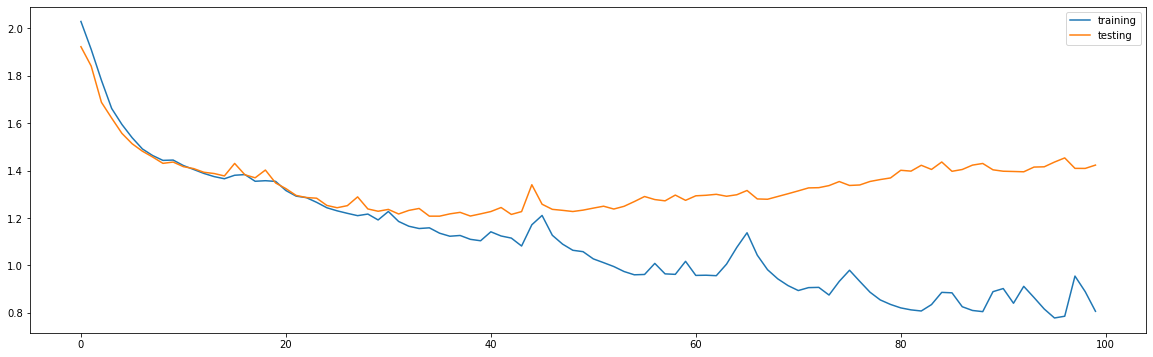

In [23]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [24]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [25]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.686771137026239

In [26]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.5255424222797928

## Model 2: Embedding-BiLSTM-BiLSTM Encoder, LSTM-Dense Decoder

In [27]:
wandb.init(project='Keras_runs', entity='nbg')

epoch,99
loss,0.80655
val_loss,1.42312
_runtime,319
_timestamp,1621778549
_step,99
best_val_loss,1.20776
best_epoch,35


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [28]:
name = 'NBG_bilstm_stacked'

In [29]:
#timesteps = 64  # Length of your sequences
embed_size = 16
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
encoded = Bidirectional(LSTM(latent_dim, return_sequences=True, dropout=dropout))(embedded)
encoded = Bidirectional(LSTM(latent_dim, dropout=dropout))(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [30]:
sequence_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 16)            608       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               559104    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 256)           787456    
_________________________________________________________________
dense_1 (Dense)              (None, 64, 38)            9766      
Total params: 1,356,934
Trainable params: 1,356,934
Non-trainable params: 0
_________________________________________________

In [31]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(2*latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [32]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 16)            608       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               559104    
Total params: 559,712
Trainable params: 559,712
Non-trainable params: 0
_________________________________________________________________


In [33]:
decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 256)           787456    
_________________________________________________________________
dense_1 (Dense)              (None, 64, 38)            9766      
Total params: 797,222
Trainable params: 797,222
Non-trainable params: 0
_________________________________________________________________


In [34]:
learning_rate = 5e-3
epochs = 100
batch_size = 32
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.model = name

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=learning_rate)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [36]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[mc, WandbCallback()])

Epoch 1/100
97/97 [==============================] - 6s 31ms/step - loss: 2.2115 - val_loss: 1.9052
Epoch 2/100
97/97 [==============================] - 2s 23ms/step - loss: 1.8821 - val_loss: 1.7987
Epoch 3/100
97/97 [==============================] - 2s 20ms/step - loss: 1.7955 - val_loss: 1.6757
Epoch 4/100
97/97 [==============================] - 2s 18ms/step - loss: 1.8636 - val_loss: 1.9517
Epoch 5/100
97/97 [==============================] - 2s 16ms/step - loss: 1.9748 - val_loss: 1.9349
Epoch 6/100
97/97 [==============================] - 2s 17ms/step - loss: 1.9674 - val_loss: 1.9329
Epoch 7/100
97/97 [==============================] - 2s 17ms/step - loss: 1.9582 - val_loss: 1.9346
Epoch 8/100
97/97 [==============================] - 2s 19ms/step - loss: 1.9687 - val_loss: 1.9306
Epoch 9/100
97/97 [==============================] - 2s 16ms/step - loss: 1.9627 - val_loss: 1.9367
Epoch 10/100
97/97 [==============================] - 2s 17ms/step - loss: 1.9612 - val_loss: 1.9272

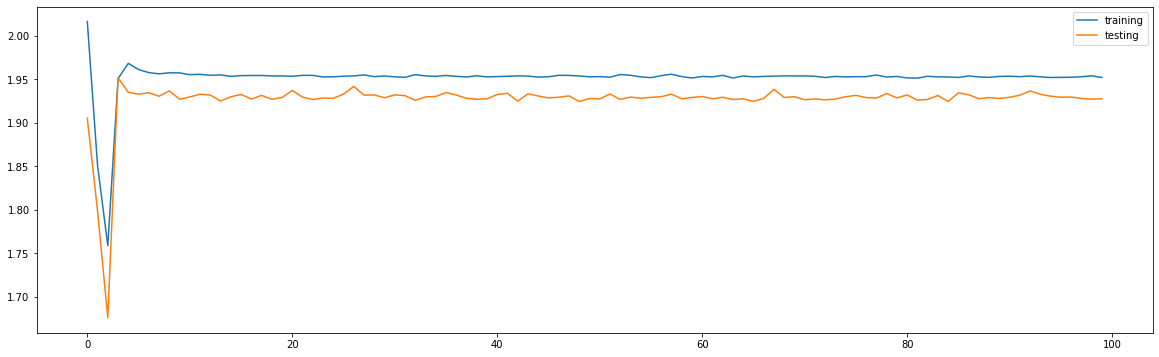

In [37]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [38]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [39]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.46820841431810817

In [40]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.4697215025906736

## Model 3 Embedding-GRU Encoder GRU-Dense Decoder

In [41]:
wandb.init(project='Keras_runs', entity='nbg')

epoch,99
loss,1.95211
val_loss,1.92773
_runtime,649
_timestamp,1621779207
_step,99
best_val_loss,1.6757
best_epoch,2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_loss,▇▁██████████████████████████████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [42]:
name = 'NBG_gru'

In [43]:
#timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
#encoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(embedded)
encoded = GRU(latent_dim, dropout=dropout)(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = GRU(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [44]:
sequence_autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 32)            1216      
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 64, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 256)           394752    
_________________________________________________________________
dense_2 (Dense)              (None, 64, 38)            9766      
Total params: 628,454
Trainable params: 628,454
Non-trainable params: 0
_____________________________________________________

In [45]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [46]:
encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 32)            1216      
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
Total params: 223,936
Trainable params: 223,936
Non-trainable params: 0
_________________________________________________________________


In [47]:
decoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 64, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 256)           394752    
_________________________________________________________________
dense_2 (Dense)              (None, 64, 38)            9766      
Total params: 404,518
Trainable params: 404,518
Non-trainable params: 0
_________________________________________________________________


In [48]:
learning_rate = 5e-3
epochs = 100
batch_size = 32
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.model = name

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=learning_rate)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [50]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[mc, WandbCallback()])

Epoch 1/100
97/97 [==============================] - 5s 25ms/step - loss: 2.2368 - val_loss: 1.7472
Epoch 2/100
97/97 [==============================] - 2s 18ms/step - loss: 1.6990 - val_loss: 1.5855
Epoch 3/100
97/97 [==============================] - 1s 14ms/step - loss: 1.5627 - val_loss: 1.4964
Epoch 4/100
97/97 [==============================] - 1s 14ms/step - loss: 1.4840 - val_loss: 1.4545
Epoch 5/100
97/97 [==============================] - 1s 12ms/step - loss: 1.4461 - val_loss: 1.4338
Epoch 6/100
97/97 [==============================] - 1s 12ms/step - loss: 1.4251 - val_loss: 1.4145
Epoch 7/100
97/97 [==============================] - 1s 11ms/step - loss: 1.4108 - val_loss: 1.4016
Epoch 8/100
97/97 [==============================] - 1s 12ms/step - loss: 1.4000 - val_loss: 1.4005
Epoch 9/100
97/97 [==============================] - 1s 14ms/step - loss: 1.3866 - val_loss: 1.3868
Epoch 10/100
97/97 [==============================] - 1s 13ms/step - loss: 1.3941 - val_loss: 1.3931

Epoch 80/100
97/97 [==============================] - 1s 13ms/step - loss: 1.3433 - val_loss: 1.3596
Epoch 81/100
97/97 [==============================] - 1s 13ms/step - loss: 1.3498 - val_loss: 1.3548
Epoch 82/100
97/97 [==============================] - 1s 12ms/step - loss: 1.3471 - val_loss: 1.3444
Epoch 83/100
97/97 [==============================] - 1s 11ms/step - loss: 1.3371 - val_loss: 1.3433
Epoch 84/100
97/97 [==============================] - 1s 13ms/step - loss: 1.3367 - val_loss: 1.3456
Epoch 85/100
97/97 [==============================] - 1s 12ms/step - loss: 1.3268 - val_loss: 1.4296
Epoch 86/100
97/97 [==============================] - 1s 14ms/step - loss: 1.3904 - val_loss: 1.3585
Epoch 87/100
97/97 [==============================] - 1s 12ms/step - loss: 1.3503 - val_loss: 1.3413
Epoch 88/100
97/97 [==============================] - 1s 11ms/step - loss: 1.3332 - val_loss: 1.3483
Epoch 89/100
97/97 [==============================] - 1s 11ms/step - loss: 1.3510 - val_los

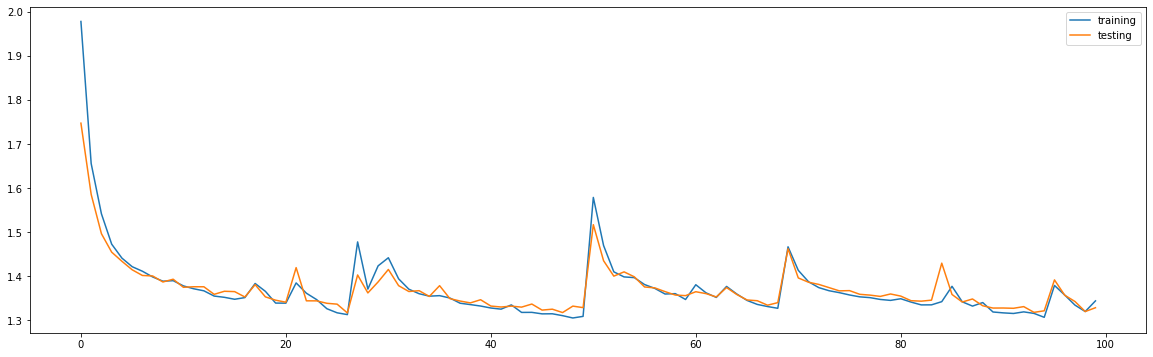

In [51]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [52]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [53]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.5053956106252024

In [54]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.50390625

## Model 4: Embedding-Conv1D-MaxPooling1D-Conv1D-MaxPooling1D-Conv1D Encoder Conv1D-Upsampling1D-Conv1D-Upsampling1D-Conv1D-Dense Decoder

In [12]:
wandb.init(project='Keras_runs', entity='nbg')

wandb: Currently logged in as: raraz15 (use `wandb login --relogin` to force relogin)


In [13]:
name = 'NBG_conv'

In [14]:
#timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
encoded = Conv1D(latent_dim, 3, activation='relu', padding='same')(embedded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(2 * latent_dim, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)

decoded = Conv1D(2 * latent_dim, 3, activation='relu', padding='same')(encoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(latent_dim, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1, 3, activation='relu', padding='same')(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [15]:
sequence_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1216      
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           24832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 512)           393728    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           786944

In [16]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(timesteps//4,2*latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-6:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [17]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1216      
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           24832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 512)           393728    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 512)           0         
Total params: 419,776
Trainable params: 419,776
Non-trainable params: 0
_____________________________________________________

In [18]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 512)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           786944    
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 32, 512)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 256)           393472    
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 64, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 1)             769       
_________________________________________________________________
dense (Dense)                (None, 64, 38)            76  

In [22]:
learning_rate = 5e-3
epochs = 5000
batch_size = 32
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.model = name

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=learning_rate)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [ ]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[mc, WandbCallback()])

Epoch 1/5000
97/97 [==============================] - 3s 18ms/step - loss: 3.4752 - val_loss: 3.0354
Epoch 2/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.9158 - val_loss: 2.5889
Epoch 3/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.5211 - val_loss: 2.3023
Epoch 4/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.2694 - val_loss: 2.1433
Epoch 5/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.1391 - val_loss: 2.0614
Epoch 6/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.0683 - val_loss: 2.0187
Epoch 7/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.0352 - val_loss: 1.9954
Epoch 8/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.0065 - val_loss: 1.9816
Epoch 9/5000
97/97 [==============================] - 1s 9ms/step - loss: 2.0104 - val_loss: 1.9724
Epoch 10/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9838 - val_loss: 1.966

Epoch 82/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9780 - val_loss: 1.9450
Epoch 83/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9752 - val_loss: 1.9449
Epoch 84/5000
97/97 [==============================] - 1s 8ms/step - loss: 1.9619 - val_loss: 1.9449
Epoch 85/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9637 - val_loss: 1.9449
Epoch 86/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9758 - val_loss: 1.9449
Epoch 87/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9781 - val_loss: 1.9448
Epoch 88/5000
97/97 [==============================] - 1s 10ms/step - loss: 1.9618 - val_loss: 1.9448
Epoch 89/5000
97/97 [==============================] - 1s 10ms/step - loss: 1.9764 - val_loss: 1.9448
Epoch 90/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9670 - val_loss: 1.9448
Epoch 91/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9692 - val_l

97/97 [==============================] - 1s 10ms/step - loss: 1.9783 - val_loss: 1.9448
Epoch 243/5000
97/97 [==============================] - 1s 11ms/step - loss: 1.9648 - val_loss: 1.9448
Epoch 244/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9637 - val_loss: 1.9448
Epoch 245/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9601 - val_loss: 1.9448
Epoch 246/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9830 - val_loss: 1.9448
Epoch 247/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9759 - val_loss: 1.9449
Epoch 248/5000
97/97 [==============================] - 1s 10ms/step - loss: 1.9683 - val_loss: 1.9448
Epoch 249/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9645 - val_loss: 1.9448
Epoch 250/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9622 - val_loss: 1.9448
Epoch 251/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9787 - val_loss:

97/97 [==============================] - 1s 9ms/step - loss: 1.9696 - val_loss: 1.9448
Epoch 403/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9771 - val_loss: 1.9448
Epoch 404/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9628 - val_loss: 1.9448
Epoch 405/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9746 - val_loss: 1.9448
Epoch 406/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9634 - val_loss: 1.9447
Epoch 407/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9690 - val_loss: 1.9448
Epoch 408/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9633 - val_loss: 1.9448
Epoch 409/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9679 - val_loss: 1.9447
Epoch 410/5000
97/97 [==============================] - 1s 10ms/step - loss: 1.9705 - val_loss: 1.9447
Epoch 411/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9632 - val_loss: 1

97/97 [==============================] - 1s 11ms/step - loss: 1.9653 - val_loss: 1.9449
Epoch 563/5000
97/97 [==============================] - 1s 12ms/step - loss: 1.9680 - val_loss: 1.9449
Epoch 564/5000
97/97 [==============================] - 1s 12ms/step - loss: 1.9737 - val_loss: 1.9448
Epoch 565/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9625 - val_loss: 1.9448
Epoch 566/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9766 - val_loss: 1.9449
Epoch 567/5000
97/97 [==============================] - 1s 10ms/step - loss: 1.9554 - val_loss: 1.9449
Epoch 568/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9703 - val_loss: 1.9448
Epoch 569/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9587 - val_loss: 1.9449
Epoch 570/5000
97/97 [==============================] - 1s 10ms/step - loss: 1.9680 - val_loss: 1.9449
Epoch 571/5000
97/97 [==============================] - 1s 9ms/step - loss: 1.9584 - val_los

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [ ]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [ ]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

In [ ]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

In [59]:
from sklearn.mixture import GaussianMixture

train_encoded = encoder(X_train).numpy()

In [60]:
gm1 = GaussianMixture(n_components=5)
gm1.fit(train_encoded.reshape(num_train, -1))

KeyboardInterrupt: 

In [ ]:
samples1 = gm1.sample(10)

samples1[0]

In [ ]:
trials = samples1[0].reshape(10, 16, 512)

In [ ]:
preds = decoder(trials).numpy().argmax(-1)

In [ ]:
preds = replace_with_dict(preds, v2n_mapping)

In [ ]:
pd.DataFrame(preds).to_csv("FirstOut.csv", index=False)

In [ ]:
pd.read_csv("FirstOut.csv")

## Model 5: Embedding-LSTM Encoder Embedding-LSTM-Dense Decoder Bassline Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(minor_data, minor_data, test_size=0.1, random_state=42)

In [ ]:
num_train = X_train.shape[0]

num_test = X_test.shape[0]

In [ ]:
#timesteps = 64

n2v_mapping['<bon/>'] = 38
v2n_mapping = {value:key for key, value in n2v_mapping.items()}
vocab_size = len(n2v_mapping)

encoder_inputs_training = X_train
decoder_inputs_training = np.ones((num_train, timesteps))
decoder_inputs_training[:,0] *= n2v_mapping['<bon/>']
decoder_inputs_training[:,1:] = X_train[:,:-1]
#decoder_outputs_training = np.ones((num_train, timesteps))
#decoder_outputs_training[:,-1] *= n2v_mapping['<bon/>']
#decoder_outputs_training[:,:-1] = X_train
#decoder_outputs_training = one_hot_encode(decoder_outputs_training, vocab_size)
decoder_outputs_training = one_hot_encode(X_train, vocab_size)

encoder_inputs_testing = X_test
decoder_inputs_testing = np.ones((num_test, timesteps))
decoder_inputs_testing[:,0] *= n2v_mapping['<bon/>']
decoder_inputs_testing[:,1:] = X_test[:,:-1]
#decoder_outputs_testing = np.ones((num_test, timesteps))
#decoder_outputs_testing[:,-1] *= n2v_mapping['<bon/>']
#decoder_outputs_testing[:,:-1] = X_test[:,1:]
#decoder_outputs_testing = one_hot_encode(decoder_outputs_testing, vocab_size)
decoder_outputs_testing = one_hot_encode(X_test, vocab_size)

In [ ]:
decoder_outputs_training.shape

In [ ]:
wandb.init(project='Keras_runs', entity='nbg')

In [ ]:
name = 'NBG_lm_lstm'

In [ ]:
embed_size = 32
latent_dim = 256
dropout = 0.

encoder_inputs = Input(shape=(timesteps,))
embedding = Embedding(vocab_size, embed_size)
encoder_embedding_outputs = embedding(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True, dropout=dropout)
encoder_outputs, state_h, state_c = encoder(encoder_embedding_outputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(timesteps,))
decoder_embedding_outputs = embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_outputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

In [ ]:
learning_rate = 5e-3
epochs = 100
batch_size = 32
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.model = name

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer, loss='categorical_crossentropy')
hist = model.fit([encoder_inputs_training, decoder_inputs_training], decoder_outputs_training,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([encoder_inputs_testing, decoder_inputs_testing], decoder_outputs_testing),
                 callbacks=[mc, WandbCallback()]
                )

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_outputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
encoder_model.summary()

In [ ]:
decoder_model.summary()

In [ ]:
results = np.zeros((num_train, timesteps))
train_encoded = encoder_model.predict(encoder_inputs_training[:,:,np.newaxis])
train_inputs = np.ones((num_train, timesteps + 1)) * n2v_mapping['<bon/>']
for i in range(timesteps):
    decoded_results = decoder_model.predict([train_inputs[:,i+1].reshape(-1, 1)] + train_encoded)
    train_encoded = decoded_results[1:]
    #preds = decoded_results[0].argmax(-1)
    train_inputs[:,i+1] = decoded_results[0].argmax(-1).reshape(-1)

In [ ]:
accuracy_score(encoder_inputs_training.reshape(-1), train_inputs[:,1:].reshape(-1))

In [ ]:
results = np.zeros((num_test, timesteps))
test_encoded = encoder_model.predict(encoder_inputs_testing[:,:,np.newaxis])
test_inputs = np.ones((num_test, timesteps + 1)) * n2v_mapping['<bon/>']
for i in range(timesteps):
    decoded_results = decoder_model.predict([test_inputs[:,i+1].reshape(-1, 1)] + test_encoded)
    test_encoded = decoded_results[1:]
    #preds = decoded_results[0].argmax(-1)
    test_inputs[:,i+1] = decoded_results[0].argmax(-1).reshape(-1)

In [ ]:
accuracy_score(encoder_inputs_testing.reshape(-1), test_inputs[:,1:].reshape(-1))

## Model 6: Variational Autoencoder

In [12]:
wandb.init(project='Keras_runs', entity='nbg')

wandb: Currently logged in as: raraz15 (use `wandb login --relogin` to force relogin)


In [14]:
name = 'NBG_vae_dense'

In [15]:
original_dim = 64
intermediate_dim = 64
latent_dim = 2
embed_size = 16

ohe_inputs = Input(shape=(original_dim, ))
embeddings = Embedding(vocab_size, embed_size)(ohe_inputs)
h = Dense(intermediate_dim, activation='relu')(embeddings)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [20]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(original_dim, latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

Tensor("lambda_3/strided_slice:0", shape=(), dtype=int32)


In [35]:
# Create encoder
encoder = Model(ohe_inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = Input(shape=(original_dim, latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(vocab_size, activation='softmax')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(ohe_inputs)[2])
vae = Model(ohe_inputs, outputs, name='vae_mlp')

In [36]:
reconstruction_loss = keras.losses.sparse_categorical_crossentropy(ohe_inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [37]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 64, 2), (Non 1956        input_4[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 64, 38)       2662        encoder[0][2]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 64, 16)       608         input_4[0][0]                    
____________________________________________________________________________________________

In [38]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 64, 2)]           0         
_________________________________________________________________
dense_15 (Dense)             (None, 64, 64)            192       
_________________________________________________________________
dense_16 (Dense)             (None, 64, 38)            2470      
Total params: 2,662
Trainable params: 2,662
Non-trainable params: 0
_________________________________________________________________


In [40]:
learning_rate = 5e-3
epochs = 100
batch_size = 32
#wandb.config.learning_rate = learning_rate
#wandb.config.epochs = epochs
#wandb.config.batch_size = batch_size
#wandb.config.model = name

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss', save_format="tf")

hist = vae.fit(X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
              callbacks=[mc]
              )

Epoch 1/100
97/97 [==============================] - 1s 12ms/step - loss: 81.4104 - val_loss: 58.3397
Epoch 2/100
97/97 [==============================] - 1s 6ms/step - loss: 43.3466 - val_loss: 32.6552
Epoch 3/100
97/97 [==============================] - 1s 6ms/step - loss: 29.0697 - val_loss: 25.5377
Epoch 4/100
97/97 [==============================] - 1s 6ms/step - loss: 23.4405 - val_loss: 20.6682
Epoch 5/100
97/97 [==============================] - 1s 6ms/step - loss: 19.1679 - val_loss: 17.2321
Epoch 6/100
97/97 [==============================] - 1s 6ms/step - loss: 16.1745 - val_loss: 14.6365
Epoch 7/100
97/97 [==============================] - 1s 6ms/step - loss: 13.8151 - val_loss: 12.5273
Epoch 8/100
97/97 [==============================] - 1s 6ms/step - loss: 11.9335 - val_loss: 10.8657
Epoch 9/100
97/97 [==============================] - 1s 6ms/step - loss: 10.3996 - val_loss: 9.5404
Epoch 10/100
97/97 [==============================] - 1s 6ms/step - loss: 9.1649 - val_loss

Epoch 23/100
97/97 [==============================] - 1s 6ms/step - loss: 3.1695 - val_loss: 3.0410
Epoch 24/100
97/97 [==============================] - 1s 6ms/step - loss: 2.9944 - val_loss: 2.8869
Epoch 25/100
97/97 [==============================] - 1s 5ms/step - loss: 2.8297 - val_loss: 2.7220
Epoch 26/100
97/97 [==============================] - 1s 6ms/step - loss: 2.6850 - val_loss: 2.5879
Epoch 27/100
97/97 [==============================] - 1s 6ms/step - loss: 2.5539 - val_loss: 2.4428
Epoch 28/100
97/97 [==============================] - 1s 6ms/step - loss: 2.4291 - val_loss: 2.3340
Epoch 29/100
97/97 [==============================] - 1s 7ms/step - loss: 2.3145 - val_loss: 2.2264
Epoch 30/100
97/97 [==============================] - 1s 6ms/step - loss: 2.2156 - val_loss: 2.1344
Epoch 31/100
97/97 [==============================] - 1s 5ms/step - loss: 2.1226 - val_loss: 2.0506
Epoch 32/100
97/97 [==============================] - 1s 6ms/step - loss: 2.0327 - val_loss: 1.9648


Epoch 45/100
97/97 [==============================] - 1s 6ms/step - loss: 1.2855 - val_loss: 1.2479
Epoch 46/100
97/97 [==============================] - 1s 5ms/step - loss: 1.2439 - val_loss: 1.2104
Epoch 47/100
97/97 [==============================] - 1s 5ms/step - loss: 1.2108 - val_loss: 1.1796
Epoch 48/100
97/97 [==============================] - 1s 5ms/step - loss: 1.1816 - val_loss: 1.1478
Epoch 49/100
97/97 [==============================] - 1s 6ms/step - loss: 1.1445 - val_loss: 1.1103
Epoch 50/100
97/97 [==============================] - 1s 6ms/step - loss: 1.1187 - val_loss: 1.0853
Epoch 51/100
97/97 [==============================] - 1s 6ms/step - loss: 1.1066 - val_loss: 1.0866
Epoch 52/100
97/97 [==============================] - 1s 6ms/step - loss: 1.0750 - val_loss: 1.0314
Epoch 53/100
97/97 [==============================] - 1s 5ms/step - loss: 1.0326 - val_loss: 1.0259
Epoch 54/100
97/97 [==============================] - 1s 6ms/step - loss: 1.0216 - val_loss: 0.9766


Epoch 67/100
97/97 [==============================] - 1s 6ms/step - loss: 0.7540 - val_loss: 0.7336
Epoch 68/100
97/97 [==============================] - 1s 6ms/step - loss: 0.8157 - val_loss: 0.7335
Epoch 69/100
97/97 [==============================] - 1s 6ms/step - loss: 0.7410 - val_loss: 0.7498
Epoch 70/100
97/97 [==============================] - 1s 6ms/step - loss: 0.7169 - val_loss: 0.6990
Epoch 71/100
97/97 [==============================] - 1s 6ms/step - loss: 0.6971 - val_loss: 0.6955
Epoch 72/100
97/97 [==============================] - 1s 6ms/step - loss: 0.6832 - val_loss: 0.6686
Epoch 73/100
97/97 [==============================] - 1s 6ms/step - loss: 0.7239 - val_loss: 0.6967
Epoch 74/100
97/97 [==============================] - 1s 6ms/step - loss: 0.6715 - val_loss: 0.6720
Epoch 75/100
97/97 [==============================] - 1s 6ms/step - loss: 0.6412 - val_loss: 0.6584
Epoch 76/100
97/97 [==============================] - 1s 6ms/step - loss: 0.6940 - val_loss: 0.6341


Epoch 89/100
97/97 [==============================] - 1s 6ms/step - loss: 0.5400 - val_loss: 0.5106
Epoch 90/100
97/97 [==============================] - 1s 6ms/step - loss: 0.5367 - val_loss: 0.5348
Epoch 91/100
97/97 [==============================] - 1s 7ms/step - loss: 0.5909 - val_loss: 0.5184
Epoch 92/100
97/97 [==============================] - 1s 5ms/step - loss: 0.5355 - val_loss: 0.5211
Epoch 93/100
97/97 [==============================] - 1s 5ms/step - loss: 0.4972 - val_loss: 0.5006
Epoch 94/100
97/97 [==============================] - 1s 6ms/step - loss: 0.5360 - val_loss: 0.4992
Epoch 95/100
97/97 [==============================] - 1s 6ms/step - loss: 0.5079 - val_loss: 0.4902
Epoch 96/100
97/97 [==============================] - 1s 6ms/step - loss: 0.4790 - val_loss: 0.5127
Epoch 97/100
97/97 [==============================] - 0s 5ms/step - loss: 0.4755 - val_loss: 0.4736
Epoch 98/100
97/97 [==============================] - 1s 6ms/step - loss: 0.4932 - val_loss: 0.4911


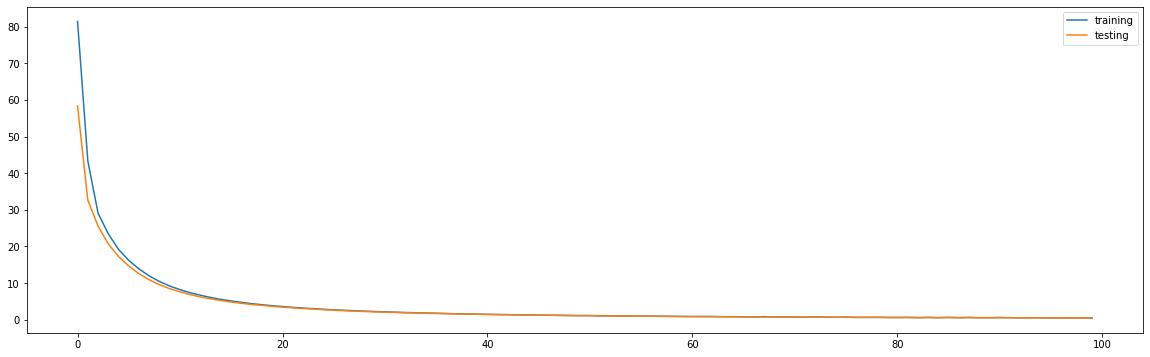

In [41]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [42]:
vae = load_model(f'Models/{name}.hdf5')

In [45]:
preds = vae(X_train).numpy().argmax(-1)

accuracy_score(X_train.reshape(-1), preds.reshape(-1))

0.9999696307094267

In [46]:
preds = vae(X_test).numpy().argmax(-1)

accuracy_score(X_test.reshape(-1), preds.reshape(-1))

0.9999595207253886

In [24]:
n=30

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
lst=[]

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]] * 64)[np.newaxis,:,:]
        x_decoded = decoder.predict(z_sample)
        lst.append(x_decoded)

In [ ]:
preds = decoder.predict(np.random.normal(size=(10, 64, 2)))
preds.argmax(-1)

In [ ]:
generation = decoder(np.random.normal(size=(10, 64, 2))).numpy()

In [ ]:
train_encoded = encoder(y_train)[2].numpy()

In [ ]:
[[1,2]] * 10

In [ ]:
train_encoded[0]

In [ ]:
decoder.predict(train_encoded).argmax(-1)

In [ ]:
generation.argmax(-1)

In [ ]:
x_test_encoded = encoder.predict(y_test, batch_size=32)[2]

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
x_test_encoded[2].shape